<a href="https://colab.research.google.com/github/ShuaimingJing/XAI_assignment/blob/main/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install shap
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython


  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-4lyutwoj/alepython_2b4239ece5ce4aefbd9ba825e5715d9b
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-4lyutwoj/alepython_2b4239ece5ce4aefbd9ba825e5715d9b
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


In [15]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Models
import xgboost
from sklearn.model_selection import train_test_split
import torchvision.models as models
from xgboost import XGBRegressor

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

# Correlation Analysis
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# Model & Data

 The California dataset from SHAP is a housing dataset that includes various features related to housing in California. The target variable is the median house value, and the goal is to predict this value based on the input features.

In [10]:
# Load Data from shap library
X,y = shap.datasets.california()

# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = xgboost.XGBRegressor().fit(X_train, y_train)
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Correlation Analysis

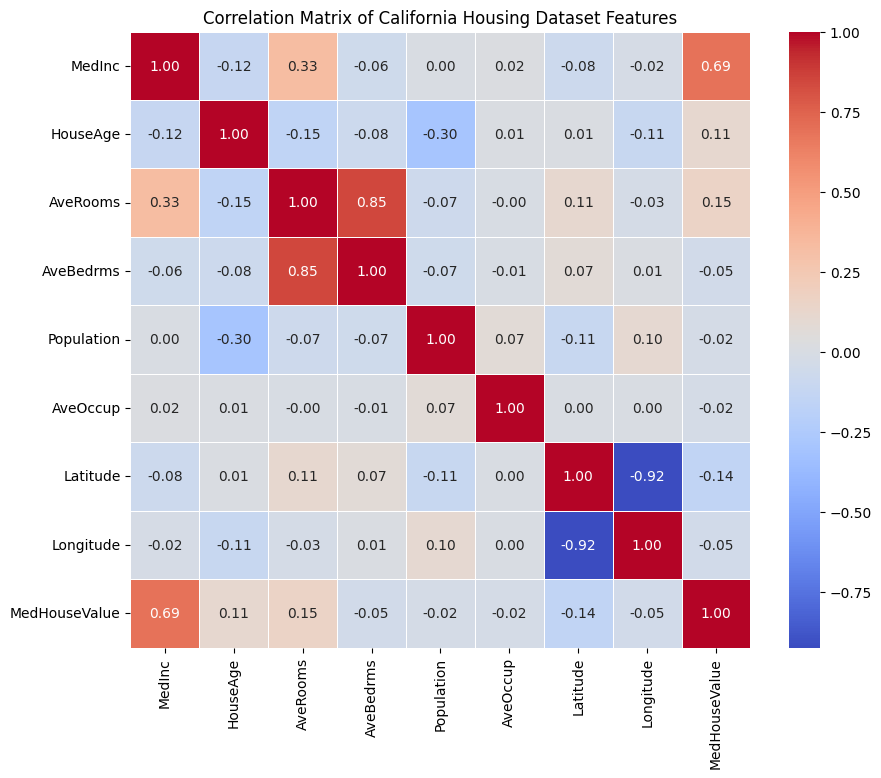

In [16]:
data = fetch_california_housing()
data_df = pd.DataFrame(data.data, columns=data.feature_names)
data_df['MedHouseValue'] = data.target  # Add the target column

# Compute the correlation matrix
corr_matrix = data_df.corr()

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of California Housing Dataset Features")
plt.show()

**Explanation:** There is a strong positive correlation between median income (MedInc) and house value (MedHouseValue). This means that as income increases in a region, house prices also tend to rise, which makes intuitive sense—wealthier areas generally have higher house prices.

The average number of rooms and average number of bedrooms are highly correlated. This is expected since homes with more rooms will typically have more bedrooms. However, this high correlation can sometimes introduce multicollinearity in models, where two features provide redundant information.

Latitude and longitude are strongly negatively correlated because of geographic positioning in California (as latitude increases, longitude tends to decrease based on the layout of the state).

**Finding**: Median income has the strongest positive correlation with house value, suggesting that it is a crucial factor in predicting house prices. This makes sense because wealthier areas tend to have more expensive homes. HouseAge, AveRooms and Latitude also play important roles in predicting the house values. In this notebook, I am going to mainly focus on the influence of the HouseAge.

# Partial Dependence Plots (PDP)

In [11]:
print(X_train.columns)  # Check the available feature names


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


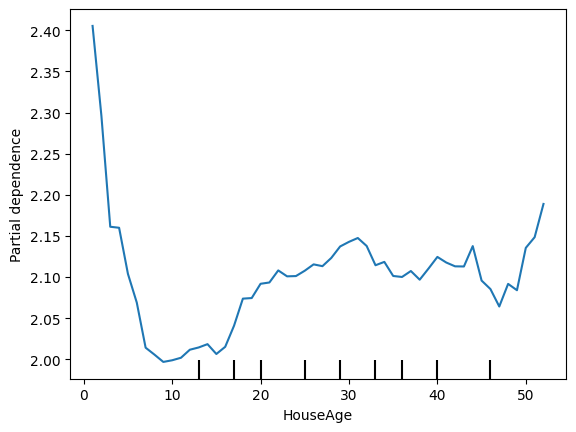

In [12]:
# Choose the feature of interest
features = ["HouseAge"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average')

**Explanation**: X-axis is the feature HouseAge. The Y-axis shows the partial dependence, which is the effect that the feature HouseAge has on the predicted target (the median house value). Higher values on the Y-axis indicate a higher predicted house value, while lower values indicate a lower predicted value.

According to this plot, newer houses (0-5 years) tend to have higher values. This makes sense as newer properties often command higher prices due to modern amenities, condition, and desirability. After around 50 years, there is a small uptick in the house value, which could be attributed to certain historical properties being valued more as they age


# Accumulated Local Effects (ALE) Plots

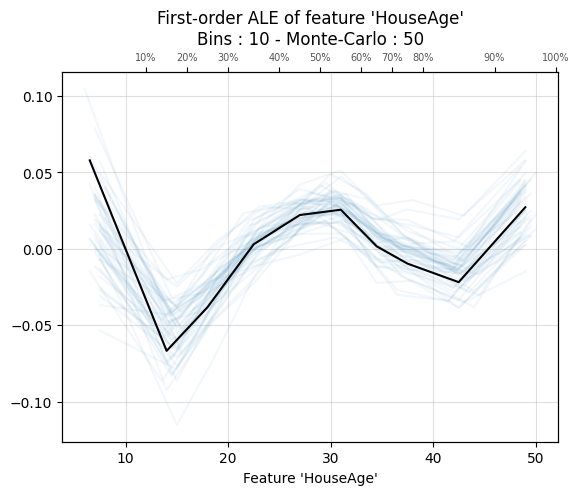

<Axes: title={'center': "First-order ALE of feature 'HouseAge'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'HouseAge'">

In [13]:
ale_plot(model, X_train, 'HouseAge', monte_carlo=True)

**Explanation**: X-axis is the feature HouseAge. Y-axis  shows the accumulated local effect of HouseAge on the predicted target (the house value). The higher the ALE value, the more positive the effect of HouseAge on the prediction.

The black line represents the average accumulated local effect across the dataset. This line is the core interpretation of the plot and shows how HouseAge impacts predictions while accounting for interactions with other features.

Shaded blue areas show uncertainty estimates obtained by Monte Carlo sampling, providing insight into the variability of the ALE at different values of HouseAge. The lighter lines show individual instances contributing to the ALE.

According to this plot, the ALE values are positive for houses that are less than 10 years old, indicating that newer houses generally increase the predicted house values. The steep decline suggests that as houses age from 0 to 10 years, the effect on house prices decreases rapidly. Then the ALE shows a sharp dip into negative values, indicating that houses between 10 and 20 years old generally reduce the predicted house values. This could be due to houses reaching a stage where they may require maintenance or updates but are not yet considered old enough to have historical value. After 40 years, the ALE value increases again, meaning that older houses tend to positively impact house value.


**Difference between PDP and ALE plot:** PDP assumes that the feature of interest (in this case, HouseAge) is independent of the other features. As a result, the PDP may overestimate or underestimate the effect of HouseAge if HouseAge is correlated with other features (such as Location or HouseSize). In the PDP for HouseAge, we saw a smoother curve that indicated a general downward trend in house value as the house gets older, with some fluctuations toward the end. It provides a global view of the effect of HouseAge across its entire range and does not differentiate between localized behaviors or effects caused by interactions with other features.

On the other hand, ALE corrects for feature correlations by focusing on localized effects of HouseAge while keeping the effect of correlated features constant. This makes ALE more robust in the presence of interactions. The ALE plot shows more localized effects, with sharper changes at specific age ranges (e.g., 0-10 years, 20-30 years). ALE also better captures the nonlinear interactions with other features. It captures localized effects, showing how the effect of HouseAge changes depending on its interaction with other features.

# Individual Conditional Expectation (ICE) Plots

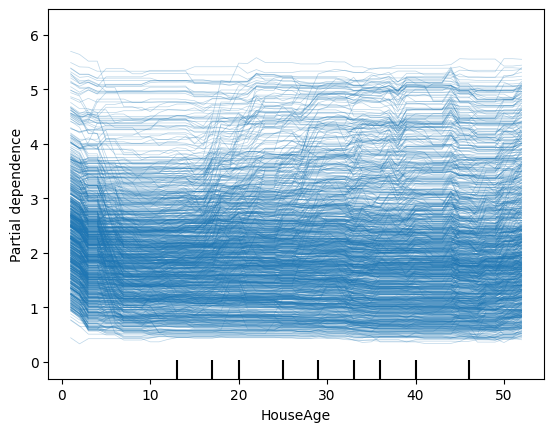

In [14]:
# Choose the feature of interest
features = ["HouseAge"]

# Use PartialDependenceDisplay to display the ICE plot
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual') #kind='individual'

**Explanation:** ICE plot visualizes the predicted response of individual (houses) to different values of HouseAge. Each line in the plot represents the response of a specific house in the dataset to varying values of HouseAge, while all other features are held constant. According to this plot, while some houses show a clear increase in predicted value as the house gets older, others do not, highlighting the complex interplay between HouseAge and other features in the model. This kind of plot is useful for understanding how different instances in the dataset respond differently to the same feature.

**Interesting findings:** PDP plot showed a slight, nonlinear effect of HouseAge on house value. Newer houses (0-10 years) saw a decline in value, while houses older than 40 years have a slight increase in value. This could because certain historical properties have valued more as they become older.

The correlation matrix showed that features like AveRooms and AveBedrms are highly correlated with each other (0.85). This will cause multicollinearity, which might affect how well a model can distinguish their individual contributions to house value. Both of these features have relatively weak correlations with house value individually, despite being highly correlated with each other.